In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import phik
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
from scipy.stats import ttest_ind, chi2_contingency
from phik import resources, report
from optuna.integration import (CatBoostPruningCallback,
                                LightGBMPruningCallback,
                                XGBoostPruningCallback
                                )
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_validate,
                                     RandomizedSearchCV,
                                     StratifiedKFold
                                    )
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

: 

: 

In [ ]:
# Loading data
X_train, X_test, y_train = pd.read_csv('X_train.csv', index_col=0), pd.read_csv('X_test.csv', index_col=0), pd.read_csv('y_train.csv', index_col=0)

In [ ]:
# Look on DF shapes
print('Size of X_train:', X_train.shape)
print('Size of X_test:', X_test.shape)
print('Size of y_train:', y_train.shape)

Size of X_train: (1199861, 44)
Size of X_test: (590977, 44)
Size of y_train: (1199861, 1)


In [ ]:
# Create DF for analysis
analysis_df = X_train
analysis_df['loan_status'] = y_train

In [ ]:
# Sample objects from DF
analysis_df.sample(5).T

index,686687,81086,504454,1183092,761790
acc_now_delinq,0.0,0.0,0.0,0.0,0.0
addr_state,TX,FL,NY,CA,CA
annual_inc,100000.0,62462.0,115000.0,28860.0,100000.0
chargeoff_within_12_mths,0.0,0.0,0.0,0.0,0.0
collections_12_mths_ex_med,0.0,0.0,0.0,0.0,0.0
delinq_2yrs,0.0,0.0,0.0,0.0,1.0
dti,4.73,26.61,13.22,24.62,11.94
earliest_cr_line,Nov-2004,Aug-1999,Apr-2005,Apr-1984,Dec-1996
emp_length,< 1 year,10+ years,4 years,10+ years,10+ years
fico_range_high,699.0,719.0,689.0,729.0,664.0


Ответим на первый вопрос

In [ ]:
analysis_df[analysis_df['addr_state'] == 'CT']['loan_status'].value_counts(normalize=True)

loan_status
0    0.824776
1    0.175224
Name: proportion, dtype: float64

**Процент невозвратных займов по штату Коннектикут составляет 17,5%**

Ответим на второй вопрос.

In [ ]:
# First sub-question
print('Соотношение трехлетних и пятилетних кредитов:', X_test['term'].value_counts(normalize=True))
print('- ' * 25)

# Second sub-question
def remove_percent(value):
    return float(value.strip('%'))

rates = analysis_df['int_rate'].apply(remove_percent)
print('Медианная процентная ставка: ', rates.median())
print('- ' * 25)

# Third sub-question
def str_to_date(value):
    return datetime.datetime.strptime(value, '%b-%Y').date()
dates = analysis_df['issue_d'].apply(str_to_date)
print('Дата последней выдачи займа train:', dates.sort_values(ascending=False).head(1))
dates = X_test['issue_d'].apply(str_to_date)
print('Дата последней выдачи займа test:', dates.sort_values(ascending=False).head(1))
print('- ' * 25)

# Fourth sub-question
print('Невозврат займа для 10% богатых:',
      analysis_df[analysis_df['annual_inc'] >= analysis_df['annual_inc'].quantile(0.9)]['loan_status'].value_counts(normalize=True))
print('Невозврат займа для остальных:',
      analysis_df[analysis_df['annual_inc'] < analysis_df['annual_inc'].quantile(0.9)]['loan_status'].value_counts(normalize=True))

Соотношение трехлетних и пятилетних кредитов: term
 36 months    0.752891
 60 months    0.247109
Name: proportion, dtype: float64
- - - - - - - - - - - - - - - - - - - - - - - - - 
Медианная процентная ставка:  12.69
- - - - - - - - - - - - - - - - - - - - - - - - - 
Дата последней выдачи займа train: index
1000908    2020-09-01
Name: issue_d, dtype: object
Дата последней выдачи займа test: index
555555    2020-09-01
Name: issue_d, dtype: object
- - - - - - - - - - - - - - - - - - - - - - - - - 
Невозврат займа для 10% богатых: loan_status
0    0.848308
1    0.151692
Name: proportion, dtype: float64
Невозврат займа для остальных: loan_status
0    0.80229
1    0.19771
Name: proportion, dtype: float64


1. В тестовой выборке действительно примерно в три раза больше займов на три года.
2. Медианная процентная ставка составляет 12.69%, а не 16.29%.
3. Дата последней выдачи займа - в сентябре 2020 года, а не в августе.
4. Дефолт для 10% самых богатых напротив, ниже чем для остальных.

Ответим на третий вопрос.

In [ ]:
# First sub-question
print('Доля проблемных счетов среди дефолтных: ', 
      (analysis_df[(analysis_df['loan_status'] == 1) & (analysis_df['acc_now_delinq'] > 0)].shape[0]) / (analysis_df[(analysis_df['loan_status'] == 1)].shape[0]))
print('Доля проблемных счетов среди нормальных: ', 
      (analysis_df[(analysis_df['loan_status'] == 0) & (analysis_df['acc_now_delinq'] > 0)].shape[0]) / (analysis_df[(analysis_df['loan_status'] == 0)].shape[0]))
print('- ' * 25)

# Second sub-question
loan = analysis_df[analysis_df['loan_status'] == 1]['fico_range_low']
normal = analysis_df[analysis_df['loan_status'] == 0]['fico_range_low']

t_statistic, p_value = ttest_ind(loan, normal)
print('H0: нижний порог от БКИ не существенно различается')
print("t-статистика:", t_statistic)
print("p-значение:", p_value)
print("P-value близок к нулю, что даёт нам право опровергнуть нулевую гипотезу.")
print('- ' * 25)

# Third sub-question
analysis_df['diff_summ'] = analysis_df['loan_amnt'] - analysis_df['funded_amnt']
loan = analysis_df[analysis_df['loan_status'] == 1]['diff_summ']
normal = analysis_df[analysis_df['loan_status'] == 0]['diff_summ']

t_statistic, p_value = ttest_ind(loan, normal)
print('H0: разницы между запрошенными и одобренными суммами не различаются')
print("t-статистика:", t_statistic)
print("p-значение:", p_value)
print("P-value значительно выше 0.5, что даёт нам право подтвердить нулевую гипотезу.")
print('- ' * 25)

# Fourth sub-question
print('Доля пропущенных значений среди невозвращенных:',
      analysis_df[(analysis_df['loan_status'] == 1) & (analysis_df['mths_since_recent_bc_dlq'].isna())].shape[0] / analysis_df[analysis_df['loan_status'] == 1].shape[0]
      )
print('Доля пропущенных значений среди нормальных:',
      analysis_df[(analysis_df['loan_status'] == 0) & (analysis_df['mths_since_recent_bc_dlq'].isna())].shape[0] / analysis_df[analysis_df['loan_status'] == 0].shape[0]
      )

Доля проблемных счетов среди дефолтных:  0.00449034575662326
Доля проблемных счетов среди нормальных:  0.004298463314856758
- - - - - - - - - - - - - - - - - - - - - - - - - 
H0: нижний порог от БКИ не существенно различается
t-статистика: -136.00226457025826
p-значение: 0.0
P-value близок к нулю, что даёт нам право опровергнуть нулевую гипотезу.
- - - - - - - - - - - - - - - - - - - - - - - - - 
H0: разницы между запрошенными и одобренными суммами не различаются
t-статистика: -0.039327929116049265
p-значение: 0.9686289461648347
P-value значительно выше 0.5, что даёт нам право подтвердить нулевую гипотезу.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Доля пропущенных значений среди невозвращенных: 0.7547234983247556
Доля пропущенных значений среди нормальных: 0.7667376191966356


1. Доля проблемных счетов действительно практически не отличается.
2. Нижний порог от БКИ ОТЛИЧАЕТСЯ.
3. Займы НЕ различаются по разнице сумм.
4. Доли пропущенных значений НЕ значимо различаются.

Ответим на четвертый вопрос.

In [ ]:
analysis_df['verification_status'].unique()

array(['Source Verified', 'Not Verified', 'Verified'], dtype=object)

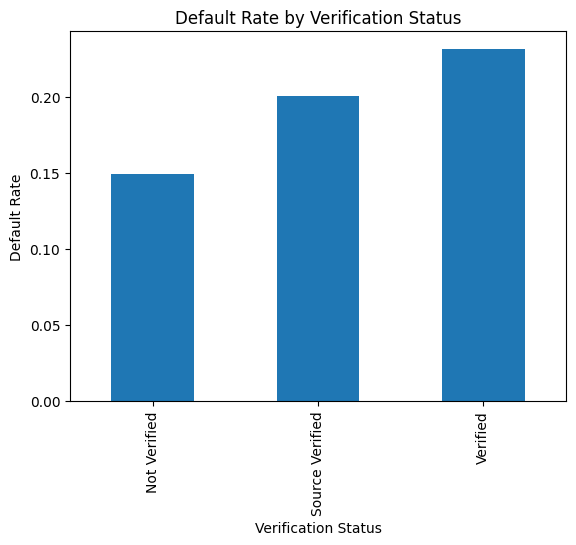

Chi-square statistic: 8070.126999811995
p-value: 0.0
Медиана дохода для верефицированных: 65000.0
Медиана дохода для неверефицированных: 65000.0
Распределение дефолта для верефицированных: loan_status
0    0.76871
1    0.23129
Name: proportion, dtype: float64
Распределение дефолта для неверефицированных: loan_status
0    0.82235
1    0.17765
Name: proportion, dtype: float64
Матрица корреляции verification_status и diff_summ
interval columns not set, guessing: ['diff_summ']
                     diff_summ  verification_status
diff_summ             1.000000             0.025445
verification_status   0.025445             1.000000


In [ ]:
# First sub-question
# Group data by verification_status and count mean loan_status
verification_group = analysis_df.groupby('verification_status')['loan_status'].mean()

# Visualization of the results
verification_group.plot(kind='bar')
plt.xlabel('Verification Status')
plt.ylabel('Default Rate')
plt.title('Default Rate by Verification Status')
plt.show()

# Make contingency table
contingency_table = pd.crosstab(analysis_df['verification_status'], analysis_df['loan_status'])

# Make Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)

# Second sub-question
print('Медиана дохода для верефицированных:', 
      analysis_df[analysis_df['verification_status'] == 'Verified']['annual_inc'].median())
print('Медиана дохода для неверефицированных:', 
      analysis_df[analysis_df['verification_status'] != 'Verified']['annual_inc'].median())

# Third sub-question
print('Распределение дефолта для верефицированных:', 
      analysis_df[analysis_df['verification_status'] == 'Verified']['loan_status'].value_counts(normalize=True))
print('Распределение дефолта для неверефицированных:', 
      analysis_df[analysis_df['verification_status'] != 'Verified']['loan_status'].value_counts(normalize=True))

# Fourth sub-question
print('Матрица корреляции verification_status и diff_summ')
print(analysis_df[['diff_summ', 'verification_status']].phik_matrix())

1. Проверка доходов клиента действительно влияет на шанс дефолта, что подтверждает график % дефолта для разных категорий верификации и хи-квадрат тест.
2. Медиана доходности верифицированных и неверефицированных клиентов одинакова.
3. Шанс дефолта для верефицированных ВЫШЕ.
4. Верификация доходов и величина loan_amnt - funded_amnt имеют незначительную корреляцию в 0.025

Ответим на пятый вопрос.

In [ ]:
# Calculate default ratio for whole train dataset
def_ratio = analysis_df['loan_status'].mean()

# Calculate default ratio with new criterions
def_ratio_new = analysis_df[(analysis_df['mort_acc'] > 0) & (analysis_df['dti'] < 0.3)]['loan_status'].mean()

# Print results
print(def_ratio_new / def_ratio)

0.7456878223183792


Шанс дефолта при заданных условиях снижается примерно на 25%

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.33, random_state=100)